In [ ]:
import glob
from tqdm import tqdm

import os
import sys 
sys.path.append("../")
import utils

import pandas as pd
import itertools 

import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set() 
from scipy.stats import pearsonr
import numpy as np



def personality_binarization(x, vid):
    """
    性格特性スコアを2クラスに分類
    """
    binary = {}
    df = pd.DataFrame.from_dict(x, orient='index')

    df = (df >= 0) * 1

    for id in vid:
        binary[id] = df.loc[id, :].tolist()

    return binary

def get_personality(hazumiversion, filename):
    """
    アノテータの質問回答から性格特性スコアを算出
    """
    if hazumiversion == "1911":
        filepath = "../../data/Hazumi/Hazumi1911/questionnaire/1911questionnaires.xlsx"
        df = pd.read_excel(filepath, sheet_name=4, header=1, index_col=0)
    elif hazumiversion == "2010":
        filepath = "../../data/Hazumi/Hazumi2010/questionnaire/questionnaires.xlsx"
        df = pd.read_excel(filepath, sheet_name=3, header=1, index_col=0)
    elif hazumiversion == "2012":
        filepath = "../../data/Hazumi/Hazumi2012/questionnaire/questionnaires.xlsx"
        df = pd.read_excel(filepath, sheet_name=3, header=1, index_col=0)
    data = df.loc[filename].values.tolist()
    return [data[0] + (8 - data[5]), (8-data[1]) + data[6], data[2] + (8-data[7]), data[3] + (8-data[8]), data[4] + (8-data[9])]

def get_third_personality(version, filename):
    """
    アノテータの質問回答から性格特性スコアを算出
    """
    if version == "1911":
        file_path = '../../data/Hazumi/Hazumi1911/questionnaire/220818thirdbigfive-Hazumi1911.xlsx'
    elif version == "2010":
        file_path = '../../data/Hazumi/Hazumi2010/questionnaire/220822thirdbigfive-Hazumi2010.xlsx'
    df = pd.read_excel(file_path, sheet_name=5, header=1, index_col=0)
    data = df.loc[filename].values.tolist()
    return [data[5], data[13], data[21], data[29], data[37]]

In [ ]:
version = "1911"
dumpfile_path = f'../../data/Hazumi/Hazumi{version}/dumpfiles/*'
files = glob.glob(dumpfile_path)

SP = {}
TP = {} 

TS = {}
TS_ternary = {}

SS = {}
SS_ternary = {} 

vid = []
for file_path in tqdm(sorted(files)):
    filename = os.path.basename(file_path).split('.', 1)[0]
    vid.append(filename)
    df = pd.read_csv(file_path)
    # 本人心象
    SS[filename] = df.loc[:, 'SS'].astype(int).values.tolist()
    SS_ternary[filename] = df.loc[:, 'SS_ternary'].astype(int).values.tolist()
    # 第三者心象
    TS[filename] = df.loc[:, 'TS1':'TS5'].mean(axis='columns').values.tolist()
    TS_ternary[filename] = df.loc[:, "TS_ternary"].astype(int).values.tolist()

    # 本人性格特性
    SP[filename] = get_personality(version, filename)
    # 第三者性格特性
    TP[filename] = get_third_personality(version, filename)
    
# 本人性格特性
SP_scaled = utils.dict_standardize(SP, vid)
SP_binary = personality_binarization(SP_scaled, vid)
SP_cluster = utils.clustering(SP_scaled, vid, n_clusters=4)

# 第三者性格特性
TP_scaled = utils.dict_standardize(TP, vid)
TP_binary = personality_binarization(TP_scaled, vid)
TP_cluster = utils.clustering(TP_scaled, vid, n_clusters=4)

In [ ]:
df_third = pd.DataFrame.from_dict(TP, orient="index", columns=["E(third)","A(third)", "C(third)", "N(third)", "O(third)"])
df_third_cluster = pd.DataFrame.from_dict(TP_cluster, orient="index", columns=["cluster(third)"])
df_third = pd.concat([df_third, df_third_cluster], axis=1)

df_self = pd.DataFrame.from_dict(SP, orient="index", columns=["E","A", "C", "N", "O"])
df_self_cluster = pd.DataFrame.from_dict(SP_cluster, orient="index", columns=["cluster"])
df_self = pd.concat([df_self, df_self_cluster], axis=1)

df = pd.concat([df_self, df_third], axis=1)
df["diff(E)"] = df["E"] - df["E(third)"]
df["diff(A)"] = df["A"] - df["A(third)"]
df["diff(C)"] = df["C"] - df["C(third)"]
df["diff(N)"] = df["N"] - df["N(third)"]
df["diff(O)"] = df["O"] - df["O(third)"]

In [ ]:
def calc_p(df):
    for i, j in itertools.combinations(df, 2):
        x = df.loc[:, [i]].values 
        y = df.loc[:, [j]].values 
        a, b = pearsonr(np.ravel(x), np.ravel(y))
        if 0 != b.round(10) < 0.10:
            print("=" * 45)
            print(i + "----" + j)
            print("correlation coeffieient : ", a.round(4))
            print("p value : ", b.round(4))
    print("\n")

In [ ]:
trait = "E"
df_E = df.loc[:, [f"{trait}(third)", "diff(E)", "diff(A)", "diff(C)", "diff(N)", "diff(O)"]]
print(f"trait : {trait}")
print(round(df_E.corr()[f'{trait}(third)'], 2))
calc_p(df_E)

trait = "A"
df_A = df.loc[:, [f"{trait}(third)", "diff(E)", "diff(A)", "diff(C)", "diff(N)", "diff(O)"]]
print(f"trait : {trait}")
print(round(df_A.corr()[f'{trait}(third)'], 2))
calc_p(df_A)

trait = "C"
df_C = df.loc[:, [f"{trait}(third)", "diff(E)", "diff(A)", "diff(C)", "diff(N)", "diff(O)"]]
print(f"trait : {trait}")
print(round(df_C.corr()[f'{trait}(third)'], 2))
calc_p(df_C)

trait = "N"
df_N = df.loc[:, [f"{trait}(third)", "diff(E)", "diff(A)", "diff(C)", "diff(N)", "diff(O)"]]
print(f"trait : {trait}")
print(round(df_N.corr()[f'{trait}(third)'], 2))
calc_p(df_N)

trait = "O"
df_O = df.loc[:, [f"{trait}(third)", "diff(E)", "diff(A)", "diff(C)", "diff(N)", "diff(O)"]]
print(f"trait : {trait}")
print(round(df_O.corr()[f'{trait}(third)'], 2))
calc_p(df_O)

# Hazumi1911と2010の統合

In [ ]:
version = "2010"
dumpfile_path = f'../../data/Hazumi/Hazumi{version}/dumpfiles/*'
files = glob.glob(dumpfile_path)

vid_2010 = []
SP_2010 = {}
TP_2010 = {} 

TS_2010 = {}
# TS_ternary = {}

vid = []
for file_path in tqdm(sorted(files)):
    filename = os.path.basename(file_path).split('.', 1)[0]
    vid_2010.append(filename)
    df = pd.read_csv(file_path)
    # 第三者心象
    TS_2010[filename] = df.loc[:, 'TS1':'TS3'].mean(axis='columns').values.tolist()
    # TS_ternary[filename] = df.loc[:, "TS_ternary"].astype(int).values.tolist()

    # 本人性格特性
    SP_2010[filename] = get_personality(version, filename)
    # 第三者性格特性
    TP_2010[filename] = get_third_personality(version, filename)
    
# 本人性格特性
SP_scaled_2010 = utils.dict_standardize(SP_2010, vid_2010)
SP_binary_2010 = personality_binarization(SP_scaled_2010, vid_2010)
SP_cluster_2010 = utils.clustering(SP_scaled_2010, vid_2010, n_clusters=4)

# 第三者性格特性
TP_scaled_2010 = utils.dict_standardize(TP_2010, vid_2010)
TP_binary_2010 = personality_binarization(TP_scaled_2010, vid_2010)
TP_cluster_2010 = utils.clustering(TP_scaled_2010, vid_2010, n_clusters=4)

In [ ]:
TP_all = {}
TP_all.update(TP)
TP_all.update(TP_2010)
TP_all

SP_all = {}
SP_all.update(SP)
SP_all.update(SP_2010)
SP_all

In [ ]:
df_third = pd.DataFrame.from_dict(TP_all, orient="index", columns=["E(third)","A(third)", "C(third)", "N(third)", "O(third)"])

df_self = pd.DataFrame.from_dict(SP_all, orient="index", columns=["E","A", "C", "N", "O"])

df = pd.concat([df_self, df_third], axis=1)
df["diff(E)"] = df["E"] - df["E(third)"]
df["diff(A)"] = df["A"] - df["A(third)"]
df["diff(C)"] = df["C"] - df["C(third)"]
df["diff(N)"] = df["N"] - df["N(third)"]
df["diff(O)"] = df["O"] - df["O(third)"]

In [ ]:
trait = "E"
df_E = df.loc[:, [f"{trait}(third)", "diff(E)", "diff(A)", "diff(C)", "diff(N)", "diff(O)"]]
print(f"trait : {trait}")
print(round(df_E.corr()[f'{trait}(third)'], 2))
calc_p(df_E)

trait = "A"
df_A = df.loc[:, [f"{trait}(third)", "diff(E)", "diff(A)", "diff(C)", "diff(N)", "diff(O)"]]
print(f"trait : {trait}")
print(round(df_A.corr()[f'{trait}(third)'], 2))
calc_p(df_A)

trait = "C"
df_C = df.loc[:, [f"{trait}(third)", "diff(E)", "diff(A)", "diff(C)", "diff(N)", "diff(O)"]]
print(f"trait : {trait}")
print(round(df_C.corr()[f'{trait}(third)'], 2))
calc_p(df_C)

trait = "N"
df_N = df.loc[:, [f"{trait}(third)", "diff(E)", "diff(A)", "diff(C)", "diff(N)", "diff(O)"]]
print(f"trait : {trait}")
print(round(df_N.corr()[f'{trait}(third)'], 2))
calc_p(df_N)

trait = "O"
df_O = df.loc[:, [f"{trait}(third)", "diff(E)", "diff(A)", "diff(C)", "diff(N)", "diff(O)"]]
print(f"trait : {trait}")
print(round(df_O.corr()[f'{trait}(third)'], 2))
calc_p(df_O)

Text(0, 0.5, 'third person annotation')

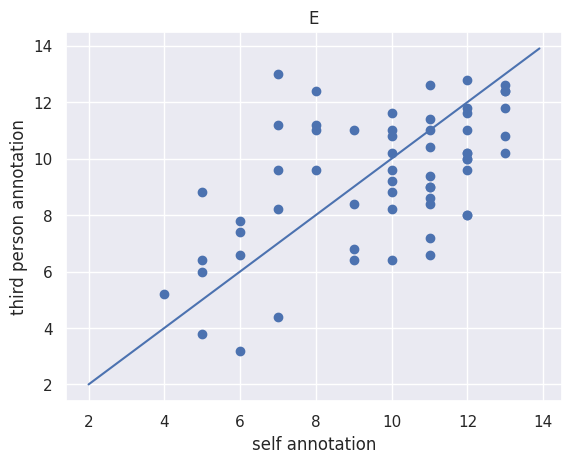

In [51]:
from scipy import stats
x = np.arange(2, 14, 0.1)
plt.plot(x, x)
plt.scatter(df.loc[:, "E"], df.loc[:, "E(third)"])
plt.title("E")
plt.xlabel("self annotation")
plt.ylabel("third person annotation")

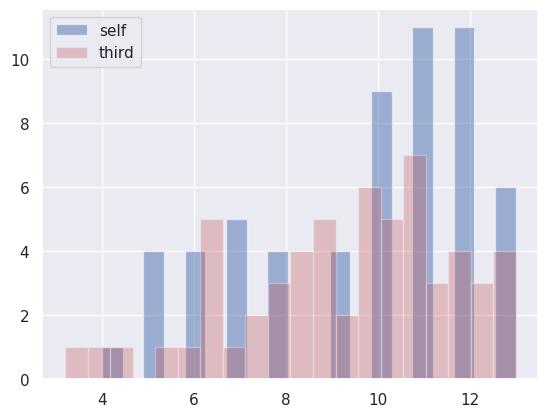

In [25]:
plt.hist(df['E'], alpha=0.5, bins=20, label="self")
plt.hist(df['E(third)'], alpha=0.3, bins=20, label="third", color='r')
plt.legend()

Text(0, 0.5, 'third person annotation')

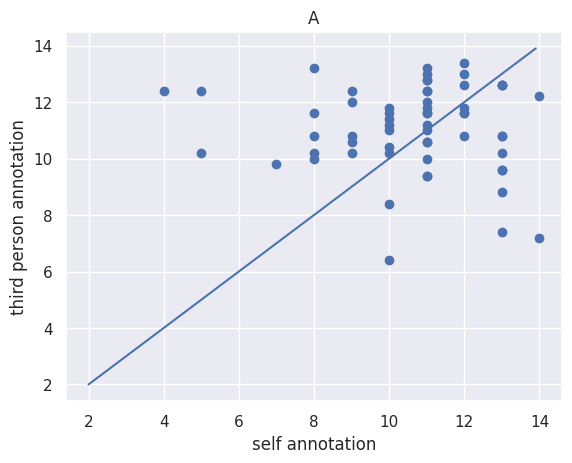

In [52]:
x = np.arange(2, 14, 0.1)
plt.plot(x, x)
plt.scatter(df.loc[:, "A"], df.loc[:, "A(third)"])
plt.title("A")
plt.xlabel("self annotation")
plt.ylabel("third person annotation")